### Residual Networks
    Welcome to the first assignment of this week! You'll be building a very deep convolutional network, using Residual Networks (ResNets). In theory, very deep networks can represent very complex functions; but in practice, they are hard to train. Residual Networks, introduced by He et al., allow you to train much deeper networks than were previously feasible.

    By the end of this assignment, you'll be able to:

    - Implement the basic building blocks of ResNets in a deep neural network using Keras
    - Put together these building blocks to implement and train a state-of-the-art neural network for image classification
    - Implement a skip connection in your network
    
    For this assignment, you'll use Keras.

    Before jumping into the problem, run the cell below to load the required packages.

**Table of Contents**
- 1 - Packages
- 2 - The Problem of Very Deep Neural Networks
- 3 - Building a Residual Network
    - 3.1 - The Identity Block
        - Exercise 1 - identity_block
    - 3.2 - The Convolutional Block
        - Exercise 2 - convolutional_block
- 4 - Building Your First ResNet Model (50 layers)
    - Exercise 3 - ResNet50
- 5 - Test on Your Own Image (Optional/Ungraded)
- 6 - Bibliography

In [23]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tensorflow.keras import layers as tfl
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

from tensorflow.keras.preprocessing import image
from tensorflow.python.framework.ops import EagerTensor


np.random.seed(0)
tf.random.set_seed(0)

%matplotlib inline

### 2 - The Problem of Very Deep Neural Networks
    Last week, you built your first convolutional neural networks: first manually with numpy, then using Tensorflow and Keras.

    In recent years, neural networks have become much deeper, with state-of-the-art networks evolving from having just a few layers (e.g., AlexNet) to over a hundred layers.

    The main benefit of a very deep network is that it can represent very complex functions. It can also learn features at many different levels of abstraction, from edges (at the shallower layers, closer to the input) to very complex features (at the deeper layers, closer to the output).

    However, using a deeper network doesn't always help. A huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent prohibitively slow.

    More specifically, during gradient descent, as you backpropagate from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode," from gaining very large values).

    During training, you might therefore see the magnitude (or norm) of the gradient for the shallower layers(initial layers) decrease to zero very rapidly as training proceeds, as shown below:
    
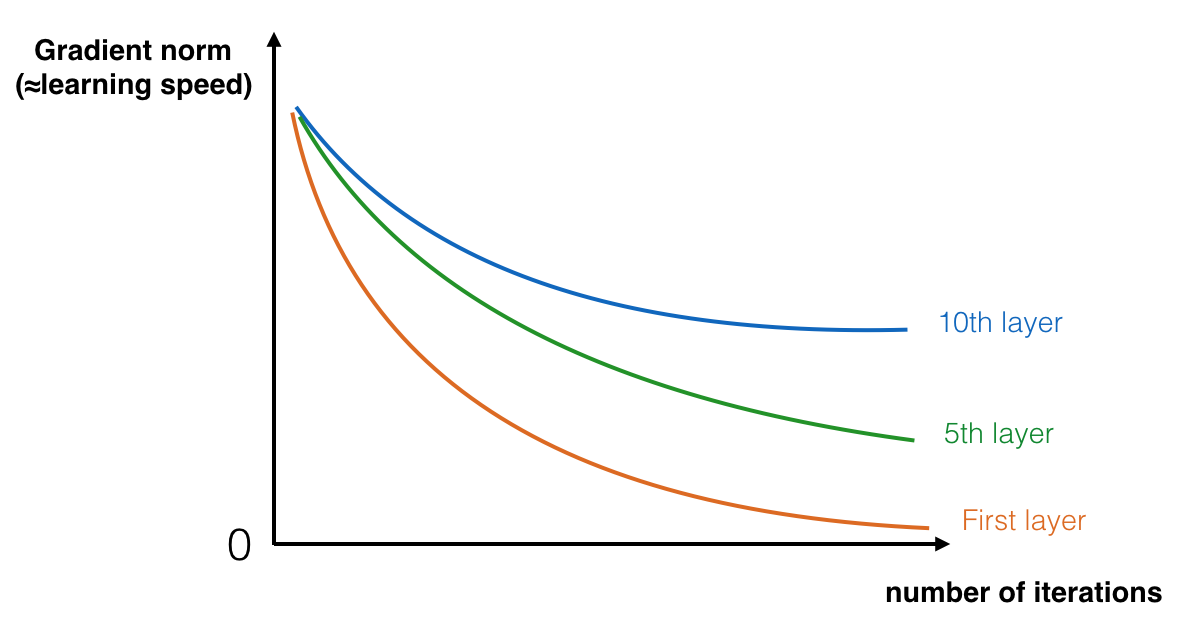
Figure 1 : Vanishing gradient

    The speed of learning decreases very rapidly for the shallower layers as the network trains
    Not to worry! You are now going to solve this problem by building a Residual Network!

### 3 - Building a Residual Network
    In ResNets, a "shortcut" or a "skip connection" allows the model to skip layers:
    
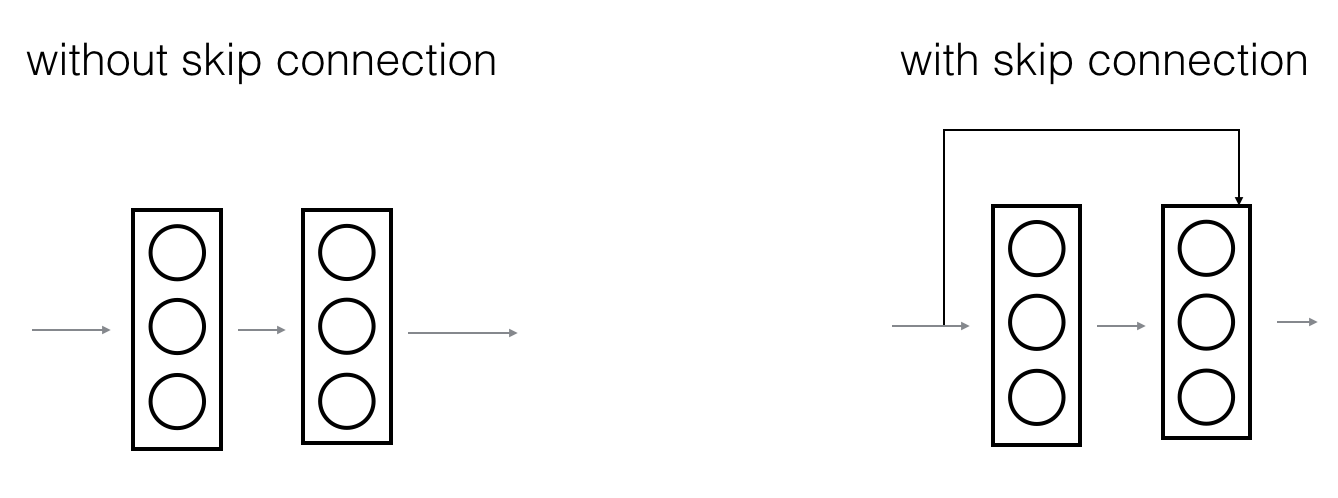
Figure 2 : A ResNet block showing a skip-connection

    The image on the left shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, you can form a very deep network.

    The lecture mentioned that having ResNet blocks with the shortcut also makes it very easy for one of the blocks to learn an identity function. This means that you can stack on additional ResNet blocks with little risk of harming training set performance.

    On that note, there is also some evidence that the ease of learning an identity function accounts for ResNets' remarkable performance even more than skip connections help with vanishing gradients.

    Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are the same or different. You are going to implement both of them: 

- The "identity block" and 
- The "convolutional block."

### 3.1 - The Identity Block
    The identity block is the standard block used in ResNets, and corresponds to the case where the input activation 
(say $a^{[l]}$) has the same dimension as the output activation (say a^{[l+2]}).
   
    To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps:

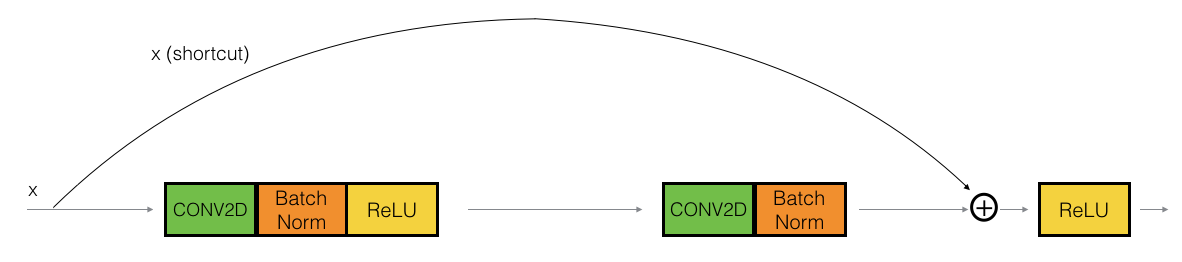
    Figure 3 : Identity block. Skip connection "skips over" 2 layers.

    The upper path is the "shortcut path." The lower path is the "main path."
    
    In this diagram, notice the CONV2D and ReLU steps in each layer. To speed up training, a BatchNorm step has been added. Don't worry about this being complicated to implement--you'll see that BatchNorm is just one line of code in Keras!

    In this exercise, you'll actually implement a slightly more powerful version of this identity block, in which the skip connection "skips over" 3 hidden layers rather than 2 layers. It looks like this:

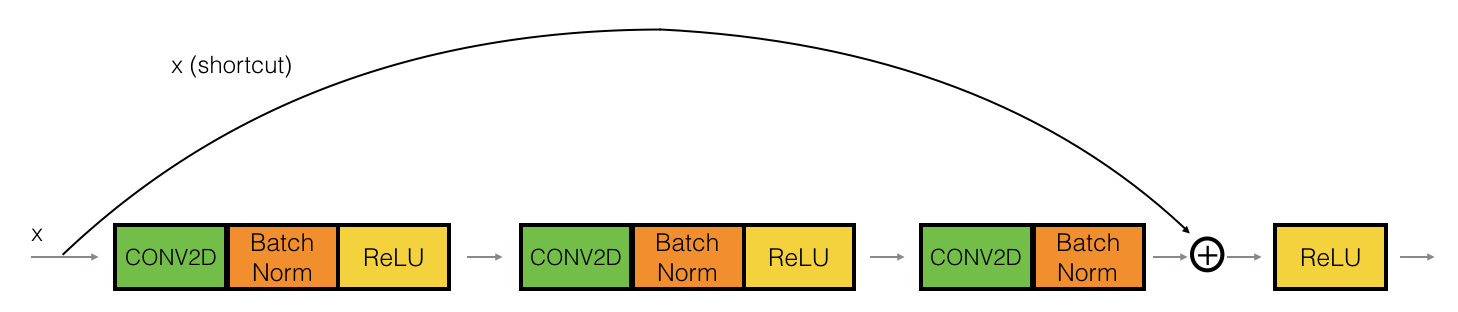
Figure 4 : Identity block. Skip connection "skips over" 3 layers.
    
These are the individual steps:

- First component of main path:

    - The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1). 
    - Its padding is "valid".
    - Use 0 as the seed for the random uniform initialization: kernel_initializer = initializer(seed=0).
    - The first BatchNorm is normalizing the 'channels' axis. (thus means, doing the normalization for batch m examples for each channel separately)https://stackoverflow.com/questions/45799926/why-batch-normalization-over-channels-only-in-cnn
    https://www.baeldung.com/cs/batch-normalization-cnn
    - Then apply the ReLU activation function. This has no hyperparameters.
    
- Second component of main path:

    - The second CONV2D has $F_2$ filters of shape (f, f) and a stride of (1,1).
    - Its padding is "same". 
    - Use 0 as the seed for the random uniform initialization: kernel_initializer = initializer(seed=0).
    - The second BatchNorm is normalizing the 'channels' axis.
    - Then apply the ReLU activation function. This has no hyperparameters.
    
- Third component of main path:

    - The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1).
    - Its padding is "valid". 
    - Use 0 as the seed for the random uniform initialization: kernel_initializer = initializer(seed=0).
    - The third BatchNorm is normalizing the 'channels' axis.
    - Note that there is **no** ReLU activation function in this component.
    
- Final step:

    - The X_shortcut and the output from the 3rd layer X are added together.
        - Hint: The syntax will look something like Add()([var1,var2])
    - Then apply the ReLU activation function. This has no hyperparameters.
    
### Exercise 1 - identity_block
    Implement the ResNet identity block. First, you should read these docs carefully to make sure you understand what's happening. Then, implement.

    - To implement the Conv2D step: tfl.Conv2D
    - To implement BatchNorm: tfl.BatchNormalization(axis = 3)(X, training = training). If training is set to False, its weights are not updated with the new examples. i.e when the model is used in prediction mode.
    - For the activation, use: tfl.Activation('relu')(X)
    - To add the value passed forward by the shortcut: tfl.Add
    
    We have added the initializer argument to our functions that serves as initializer for our kernel. This parameter receives an initializer function like the ones included in the package tensorflow.keras.initializers or any other custom initializer. By default it will be set to random_uniform

    Remember that these functions accept a seed argument that can be any value you want, but that in this notebook must set to 0 for grading purposes.

    Here is where you're actually using the power of the Functional API to create a shortcut path

In [27]:
def identity_block(X, f, layersfilters_nC, training="True", initializer=tf.keras.initializers.random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    layersfilters_nC -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X
    
    # Retrieve Filters
    F1, F2, F3 = layersfilters_nC
    
    #first component  of main path
    X = tfl.Conv2D(filters=F1, kernel_size=1, strides=(1, 1), padding="valid", kernel_initializer=initializer(seed=0))(X) 
    #using 1x1, with stride 1, this results in same spatial dimensions as input eventhough its valid padding, channels depends on nC though
    X = tfl.BatchNormalization(axis=3)(X, training=training)
    X = tfl.Activation("relu")(X)
    
    #second component  of main path
    X = tfl.Conv2D(filters=F2, kernel_size=f, strides=(1, 1), padding="same", kernel_initializer=initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis=3)(X, training=training)
    X = tfl.Activation("relu")(X)
    
    #third component  of main path
    X = tfl.Conv2D(filters=F3, kernel_size=1, strides=(1, 1), padding="valid", kernel_initializer=initializer(seed=0))(X)
    #this results in similar spatial dimensions to previous X, and the nC filters => channels will be given as equal to i/p X channels 
    #to get same shape as i/p
    X = tfl.BatchNormalization(axis=3)(X, training=training)
    
    #Final Step of shortcutpath
    X = tfl.Add()([X_shortcut, X])
    X = tfl.Activation("relu")(X)
    
    return X

In [26]:
#test the function identity_block

#creating dummy input X
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3
X = np.concatenate((X1, X2, X3), axis=0).astype(np.float32)
print(X.shape)

A3 = identity_block(X, f=2, layersfilters_nC=[4, 4, 3], training=False,
                   initializer=lambda seed=0 : tf.keras.initializers.constant(value=1),
                   )

#nC filters becomes channels,layersfilters_nC= [4, 4, 3] and the filtersize and strides makes the identity mapping of shortcut path
print(A3.shape)
print("A3 \n"+str(A3))

print('\n\033[1mWith training=False\033[0m\n')

A3np = A3.numpy() #A3 is a tensor, so accessing values using numpy
print("Round value:\n"+str(np.around(A3np[:, (0, -1), :, :].mean(axis=3), decimals=5))) #returns 3D matrix as we have 3 :'s'
#first : => accessing all 3D matrices from 4 3D matrices => all m examples
#second (0, -1) => accessing 0th and last batch of inner 3D matrices where a batch  is 2D matrix of 3D matrix => 0th row, last row in all images
#third : -> all rows in a inner 2D matrix => all coumns in an image
#fourth : -> all columns in an 2D matrix => all channels in an image
#mean is calculating mean of all channels seperately
#in the result, mean results in same value of first row, last row of each example cuz all channels values are equal. so mean gives same value

resume = A3np[:, (0, -1), :, :].mean(axis = 3) #same as previos that results in 3D matrix
print("\nResume value:\n"+str(resume[1, 1, 0])) #accessing 2nd row 2nd column first channel -> in other way its 2nd batch, second row, 1st column

print('\n\033[1mWith training=True\033[0m\n')
np.random.seed(1)
A4 = identity_block(X, f=2, layersfilters_nC=[3, 3, 3],
                   initializer=lambda seed=0:tf.keras.initializers.constant(value=1),
                   training=True)
print(np.around(A4.numpy()[:, (0, -1), :, :].mean(axis=3), 5))


(3, 4, 4, 3)
(3, 4, 4, 3)
A3 
tf.Tensor(
[[[[  0.        0.        0.     ]
   [  0.        0.        0.     ]
   [  0.        0.        0.     ]
   [  0.        0.        0.     ]]

  [[  0.        0.        0.     ]
   [  0.        0.        0.     ]
   [  0.        0.        0.     ]
   [  0.        0.        0.     ]]

  [[  0.        0.        0.     ]
   [  0.        0.        0.     ]
   [  0.        0.        0.     ]
   [  0.        0.        0.     ]]

  [[  0.        0.        0.     ]
   [  0.        0.        0.     ]
   [  0.        0.        0.     ]
   [  0.        0.        0.     ]]]


 [[[192.71233 192.71233 192.71233]
   [192.71233 192.71233 192.71233]
   [192.71233 192.71233 192.71233]
   [ 96.85616  96.85616  96.85616]]

  [[192.71233 192.71233 192.71233]
   [192.71233 192.71233 192.71233]
   [192.71233 192.71233 192.71233]
   [ 96.85616  96.85616  96.85616]]

  [[192.71233 192.71233 192.71233]
   [192.71233 192.71233 192.71233]
   [192.71233 192.71233 192.71233]


### 3.2 - The Convolutional Block
    The ResNet "convolutional block" is the second block type. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path:
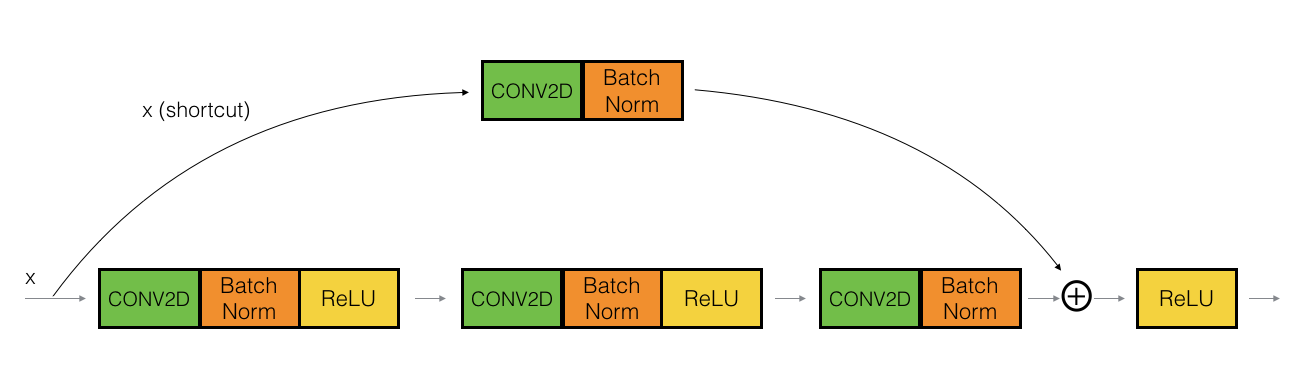
Figure 4 : Convolutional block

- The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. (This plays a similar role as the matrix $W_s$ discussed in lecture.)
    
- For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2.

- The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step.

- As for the previous exercise, the additional initializer argument is required for grading purposes, and it has been set by default to "glorot_uniform"

**The details of the convolutional block are as follows.**

- First component of main path:

    - The first CONV2D has $F_1$ filters of shape (1, 1) and a stride of (s, s). Its padding is "valid". Use 0 as the glorot_uniform seed kernel_initializer = initializer(seed=0).
    - The first BatchNorm is normalizing the 'channels' axis.
    - Then apply the ReLU activation function. This has no hyperparameters.
    
- Second component of main path:

    - The second CONV2D has $F_2$ filters of shape (f, f) and a stride of (1, 1). Its padding is "same". Use 0 as the glorot_uniform seed kernel_initializer = initializer(seed=0).
    - The second BatchNorm is normalizing the 'channels' axis.
    - Then apply the ReLU activation function. This has no hyperparameters.
    
- Third component of main path:

    - The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the glorot_uniform seed kernel_initializer = initializer(seed=0).
    - The third BatchNorm is normalizing the 'channels' axis. 
    - Note that there is no ReLU activation function in this component.
    
- Shortcut path:

    - The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s, s). Its padding is "valid". Use 0 as the glorot_uniform seed kernel_initializer = initializer(seed=0).
    - The BatchNorm is normalizing the 'channels' axis.
    
- Final step:

    - The shortcut and the main path values are added together.
    - Then apply the ReLU activation function. This has no hyperparameters.


### Exercise 2 - convolutional_block
    Implement the convolutional block. As before, always use 0 as the seed for the random initialization, to ensure consistency with the grader.

    - Conv2D
    - BatchNormalization (axis: Integer, the axis that should be normalized (typically the features axis)). BatchNormalization(axis = 3)(X, training = training). If training is set to False, its weights are not updated with the new examples. i.e when the model is used in prediction mode.
    - For the activation, use: Activation('relu')(X)
    - Add
    
    We have added the initializer argument to our functions. This parameter receives an initializer function like the ones included in the package tensorflow.keras.initializers or any other custom initializer. By default it will be set to glorot_uniform

    Remember that these functions accept a seed argument that can be any value you want, but that in this notebook must set to 0 for grading purposes.

In [114]:
def convolutional_block(X, f, layersfilters_nC, s=2, training="True", initializer=tf.keras.initializers.glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    layersfilters_nC -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X
    
    # Retrieve Filters
    F1, F2, F3 = layersfilters_nC
    
    #first component  of main path
    X = tfl.Conv2D(filters=F1, kernel_size=1, strides=(s, s), padding="valid", kernel_initializer=initializer(seed=0))(X) 
    #using 1x1, with stride 1, this results in same spatial dimensions as input eventhough its valid padding, channels depends on nC though
    X = tfl.BatchNormalization(axis=3)(X, training=training)
    X = tfl.Activation("relu")(X)
    
    #second component  of main path
    X = tfl.Conv2D(filters=F2, kernel_size=f, strides=(1, 1), padding="same", kernel_initializer=initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis=3)(X, training=training)
    X = tfl.Activation("relu")(X)
    
    #third component  of main path
    X = tfl.Conv2D(filters=F3, kernel_size=1, strides=(1, 1), padding="valid", kernel_initializer=initializer(seed=0))(X)
    #this results in similar spatial dimensions to previous X, and the nC filters => channels will be given as equal to i/p X channels 
    #to get same shape as i/p
    X = tfl.BatchNormalization(axis=3)(X, training=training)
    
    #Shortcut component
    X_shortcut = tfl.Conv2D(filters=F3, kernel_size=1, strides=(s, s), padding="valid", kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = tfl.BatchNormalization(axis=3)(X_shortcut, training=training)
    
    #Final Step of shortcutpath
    X = tfl.Add()([X, X_shortcut])
    X = tfl.Activation("relu")(X)
    
    return X

In [115]:
#test the function

X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3
X = np.concatenate((X1, X2, X3), axis=0).astype(np.float32)

A3 = convolutional_block(X, f=2, layersfilters_nC=[2, 4, 6], s=2, training=False) #3 2 2 6 
#3 2 2 2 ,3 2 2 4, 3 2 2 6 

assert type(A3) == EagerTensor, "Use only tensorflow and keras functions"
assert tuple(tf.shape(A3).numpy()) == (3, 2, 2, 6), "Wrong shape."



convolutional_block_output1 = [
    [[[0.,         0.66683817, 0.,         0.,        0.888539,   0.5274254 ],
      [0.,         0.65053666, 0.,         0.,         0.8959285,  0.49965227]],
     [[0.,         0.6312079,  0.,         0.,         0.86362475, 0.47643146],
      [0.,         0.56883204, 0.,        0.,         0.8553412,  0.417093 ]]],
    [[[1.0951002,  0.,         1.5761349,  0.6267836,  0.,         0.,        ],
      [1.3594234,  0.,         1.6074152,  0.6536726,  0.,         0.,        ]],
     [[0.49971345, 0.,         0.9446775,  0.6636579,  0.,         0.,        ],
      [0.98098886, 0.,         1.0731578,  0.6013661,  0.,         0.,        ]]],
    [[[3.2853007,  0.,         4.728405,   1.8803508,  0.,         0.,        ],
      [4.07827,    0.,         4.8222456,  1.9610177,  0.,         0.,        ]],
    [[1.4991404,  0.,         2.8340323,  1.9909737,  0.,         0.,        ],
      [2.9429667,  0.,         3.2194734,  1.8040984,  0.,         0.       ]]]
]

convolutional_block_output2 = [
     [[[0.       , 2.7823157, 0.       , 0.       , 1.6960442, 2.8218517],
       [0.       , 1.5445004, 0.       , 0.       , 2.170656 , 1.3908148]],
      [[0.       , 1.9399526, 0.       , 0.       , 1.4798119, 1.9157798],
       [0.       , 0.       , 0.       , 0.9879823, 1.1234158, 0.       ]]],
     [[[0.,         0.4073585,  0.,         0.60906595, 0.61729676, 0.43824518],
       [0.,         0.4073585,  0.,         0.60906595, 0.61729676, 0.43824518]],
      [[0.,         0.4073585,  0.,         0.60906595, 0.61729676, 0.43824518],
       [0.,         0.4073585,  0.,         0.60906595, 0.61729676, 0.43824518]]],
     [[[2.6159182,  0.,         2.752994,   0.,         0.,         0.,        ],
       [3.4472604,  0.,         2.7312024,  0.03319526, 0.,         0.,        ]],
      [[0.9830525,  0.,         1.6564476,  0.9591365,  0.,         0.,        ],
       [2.5460882,  0.,         1.1291425,  0.,         0.,         0.,        ]]]
]


assert np.allclose(A3.numpy(), convolutional_block_output1), "Wrong values when training=False."
print(A3[0])


#With Trainig True
B = convolutional_block(X, f=2, layersfilters_nC = [2, 4, 6], training=True)
assert np.allclose(B.numpy(), convolutional_block_output2), "Wrong values when training=True."


print('\033[92mAll tests passed!')

tf.Tensor(
[[[0.         0.6668381  0.         0.         0.888539   0.5274254 ]
  [0.         0.6505366  0.         0.         0.8959285  0.49965227]]

 [[0.         0.6312078  0.         0.         0.86362475 0.47643146]
  [0.         0.56883204 0.         0.         0.8553412  0.417093  ]]], shape=(2, 2, 6), dtype=float32)
All tests passed!


### 4 - Building Your First ResNet Model (50 layers)
    You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.
    
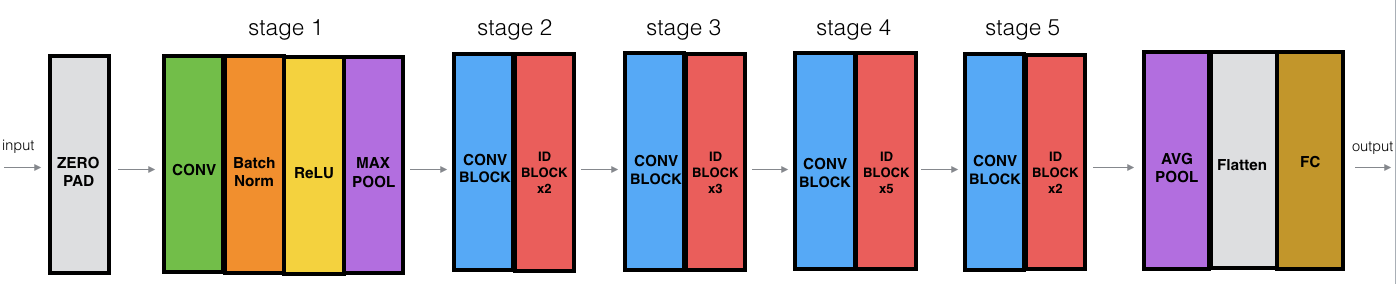
Figure 5 : ResNet-50 model

**The details of this ResNet-50 model are:**

- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2).
    - BatchNorm is applied to the 'channels' axis of the input.
    - ReLU activation is applied.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block(3 layers within) uses three sets of filters(nC) of size [64, 64, 256], "f" is 3, and "s" is 1.
    - The 2 identity blocks(3 layers each) use three sets of filters of size [64, 64, 256], and "f" is 3.

- Stage 3:
    - The convolutional block uses three sets of filters of size [128, 128, 512], "f" is 3 and "s" is 2.
    - The 3 identity blocks use three sets of filters of size [128, 128, 512] and "f" is 3.

- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.

- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.
    - The 2D Average Pooling uses a window of shape (2,2).
    - The 'flatten' layer doesn't have any hyperparameters.
    - The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

### Exercise 3 - ResNet50
    Implement the ResNet with 50 layers described in the figure above. Make sure you follow the naming convention in the text above.


You'll need to use this function:

- Average pooling see reference - https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D
- Conv2D: See reference - https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
- BatchNorm: See reference - https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization (axis: Integer, the axis that should be normalized (typically the features axis))
- Zero padding: See reference https://www.tensorflow.org/api_docs/python/tf/keras/layers/ZeroPadding2D
- Max pooling: See reference https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D
- Fully connected layer: See reference https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
- Addition: See reference https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add

In [116]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    X_input = tfl.Input(shape=input_shape) #this A0 = (64, 64, 3) 
    
    #stage 1 - 1 layer
    X1 = tfl.ZeroPadding2D(padding=(3, 3))(X_input)  #(70, 70, 3)
    X1 = tfl.Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), kernel_initializer=glorot_uniform(seed=0))(X1) #64+2*3-7/2 + 1 = (32, 32, 64) #params = 64*7*7*3 + 64
    X1 = tfl.BatchNormalization(axis=3)(X1) # (32, 32, 64) #params = scaling across channels (64)+ shifting across channels (64) + moving mean across channels(64) + moving variance across channels (64) = 256
    X1 = tfl.Activation("relu")(X1) # (32, 32, 64)
    X1 = tfl.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(X1) #32-3/2 + 1 = 15x15x64
    
    #stage 2 - 10 aggregate layers
    #convblock
    X2 = convolutional_block(X1, f=3, layersfilters_nC=[64, 64, 256], s=1, training=True, initializer=glorot_uniform) # 15x15x256 
    #IdentityBlocks x 2
    X3 = identity_block(X2, f=3, layersfilters_nC=[64, 64, 256], training=True, initializer=random_uniform) #15x15x256
    X4 = identity_block(X3, f=3, layersfilters_nC=[64, 64, 256], training=True, initializer=random_uniform) #15x15x256
    
    #stage 3 - 22 aggregate layers
    #convblock 
    X5 = convolutional_block(X4, f=3, layersfilters_nC=[128, 128, 512], s=2, training=True, initializer=glorot_uniform) #15-1/2+1 = 8x8x512
    #IdentityBlocks x 3
    X6 = identity_block(X5, f=3, layersfilters_nC=[128, 128, 512], training=True, initializer=random_uniform) #8x8x512
    X7 = identity_block(X6, f=3, layersfilters_nC=[128, 128, 512], training=True, initializer=random_uniform) #8x8x512
    X8 = identity_block(X7, f=3, layersfilters_nC=[128, 128, 512], training=True, initializer=random_uniform) #8x8x512
    
    #stage 4 - 40 aggregate layers
    #convblock
    X9 = convolutional_block(X8, f=3, layersfilters_nC=[256, 256, 1024], s=2, training=True, initializer=glorot_uniform) # 8-1/2 + 1 = (4, 4, 1024)
    #IdentityBlocks x 5
    X10 = identity_block(X9, f=3, layersfilters_nC=[256, 256, 1024], training=True, initializer=random_uniform) #(4, 4, 1024)
    X11 = identity_block(X10, f=3, layersfilters_nC=[256, 256, 1024], training=True, initializer=random_uniform) #(4, 4, 1024)
    X12 = identity_block(X11, f=3, layersfilters_nC=[256, 256, 1024], training=True, initializer=random_uniform) #(4, 4, 1024)
    X13 = identity_block(X12, f=3, layersfilters_nC=[256, 256, 1024], training=True, initializer=random_uniform) #(4, 4, 1024)
    X14 = identity_block(X13, f=3, layersfilters_nC=[256, 256, 1024], training=True, initializer=random_uniform) #(4, 4, 1024)
    
    #stage 5 - 49 aggregate layers
    #convblock
    X15 = convolutional_block(X14, f=3, layersfilters_nC=[512, 512, 2048], s=2, training=True, initializer=glorot_uniform) # 4-1/2+1 = (2, 2, 2048)
    #IdentityBlocks x 2
    X16 = identity_block(X15, f=3, layersfilters_nC=[512, 512, 2048],  training=True, initializer=random_uniform) #(2, 2, 2048)
    X17 = identity_block(X16, f=3, layersfilters_nC=[512, 512, 2048], training=True, initializer=random_uniform) #(2, 2, 2048)
    
    #Final layer - 50 aggregate layers
    P17 = tfl.AveragePooling2D(pool_size=(2, 2))(X17) #2-2/1 + 1 = (1, 1, 2048)
    F17 = tfl.Flatten()(P17) #units - 2048 or (m, 2048)
    A_out = tfl.Dense(classes, activation="softmax", kernel_initializer=glorot_uniform(seed=0))(F17) #units 6 or (m, 6) #(m, 6)
    
    model = tf.keras.models.Model(inputs=X_input, outputs=A_out)
    
    return model

    Run the following code to build the model's graph. If your implementation is incorrect, you'll know it by checking your accuracy when running model.fit(...) below.

In [117]:
model = ResNet50(input_shape=(64, 64, 3), classes=6) #builds the graph and all the parameters are initialized
print(model.summary())

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d_20 (ZeroPad  (None, 70, 70, 3)            0         ['input_21[0][0]']            
 ding2D)                                                                                          
                                                                                                  
 conv2d_1105 (Conv2D)        (None, 32, 32, 64)           9472      ['zero_padding2d_20[0][0]']   
                                                                                                  
 batch_normalization_1105 (  (None, 32, 32, 64)           256       ['conv2d_1105[0][0]']  

 batch_normalization_1113 (  (None, 15, 15, 64)           256       ['conv2d_1113[0][0]']         
 BatchNormalization)                                                                              
                                                                                                  
 activation_1030 (Activatio  (None, 15, 15, 64)           0         ['batch_normalization_1113[0][
 n)                                                                 0]']                          
                                                                                                  
 conv2d_1114 (Conv2D)        (None, 15, 15, 64)           36928     ['activation_1030[0][0]']     
                                                                                                  
 batch_normalization_1114 (  (None, 15, 15, 64)           256       ['conv2d_1114[0][0]']         
 BatchNormalization)                                                                              
          

                                                                    0]']                          
                                                                                                  
 activation_1038 (Activatio  (None, 8, 8, 512)            0         ['add_339[0][0]']             
 n)                                                                                               
                                                                                                  
 conv2d_1123 (Conv2D)        (None, 8, 8, 128)            65664     ['activation_1038[0][0]']     
                                                                                                  
 batch_normalization_1123 (  (None, 8, 8, 128)            512       ['conv2d_1123[0][0]']         
 BatchNormalization)                                                                              
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_1132 (  (None, 4, 4, 1024)           4096      ['conv2d_1132[0][0]']         
 BatchNormalization)                                                                              
                                                                                                  
 add_342 (Add)               (None, 4, 4, 1024)           0         ['batch_normalization_1131[0][
                                                                    0]',                          
                                                                     'batch_normalization_1132[0][
                                                                    0]']                          
                                                                                                  
 activation_1047 (Activatio  (None, 4, 4, 1024)           0         ['add_342[0][0]']             
 n)       

                                                                                                  
 conv2d_1141 (Conv2D)        (None, 4, 4, 1024)           263168    ['activation_1055[0][0]']     
                                                                                                  
 batch_normalization_1141 (  (None, 4, 4, 1024)           4096      ['conv2d_1141[0][0]']         
 BatchNormalization)                                                                              
                                                                                                  
 add_345 (Add)               (None, 4, 4, 1024)           0         ['activation_1053[0][0]',     
                                                                     'batch_normalization_1141[0][
                                                                    0]']                          
                                                                                                  
 activatio

 n)                                                                 0]']                          
                                                                                                  
 conv2d_1150 (Conv2D)        (None, 2, 2, 2048)           1050624   ['activation_1064[0][0]']     
                                                                                                  
 conv2d_1151 (Conv2D)        (None, 2, 2, 2048)           2099200   ['activation_1062[0][0]']     
                                                                                                  
 batch_normalization_1150 (  (None, 2, 2, 2048)           8192      ['conv2d_1150[0][0]']         
 BatchNormalization)                                                                              
                                                                                                  
 batch_normalization_1151 (  (None, 2, 2, 2048)           8192      ['conv2d_1151[0][0]']         
 BatchNorm

Total params: 23600006 (90.03 MB)
Trainable params: 23546886 (89.82 MB)
Non-trainable params: 53120 (207.50 KB)
__________________________________________________________________________________________________
None


### Some notes on non-trainable params
    In keras, non-trainable parameters (as shown in model.summary()) means the number of weights that are not updated during training with backpropagation.

    There are mainly two types of non-trainable weights:

    The ones that you have chosen to keep constant when training. This means that keras won't update these weights during training at all.
    The ones that work like statistics in BatchNormalization layers. They're updated with mean and variance, but they're not "trained with backpropagation".
    Weights are the values inside the network that perform the operations and can be adjusted to result in what we want. The backpropagation algorithm changes the weights towards a lower error at the end.

    By default, all weights in a keras model are trainable.

    When you create layers, internally it creates its own weights and they're trainable. (The backpropagation algorithm will update these weights)

    When you make them untrainable, the algorithm will not update these weights anymore. This is useful, for instance, when you want a convolutional layer with a specific filter, like a Sobel filter, for instance. You don't want the training to change this operation, so these weights/filters should be kept constant.

    There is a lot of other reasons why you might want to make weights untrainable.

    Changing parameters:

    For deciding whether weights are trainable or not, you take layers from the model and set trainable:

    model.get_layer(layerName).trainable = False #or True
    This must be done before compilation.
    
https://stackoverflow.com/questions/47312219/what-is-the-definition-of-a-non-trainable-parameter

In [46]:
#Batch Normalization params Count
count = 0
for layer in model.layers:
    if type(layer) == tf.keras.layers.BatchNormalization:
        count += layer.count_params()
        
print(count)

#total BN params are 106420 but the moving mean and moving variance are not trained usin GD. they are just chnaged with trained gamma and beta
#so the half of these params are the ones in non trainable params
        

106240


In [39]:
#Batch Normalization Conv params Count
count = 0
for layer in model.layers:
    if type(layer) == tf.keras.layers.Conv2D:
        count += layer.count_params()
        
print(count)

23481472


    As shown in the Keras Tutorial Notebook, prior to training a model, you need to configure the learning process by compiling the model.

In [118]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    The model is now ready to be trained. The only thing you need now is a dataset!

    Let's load your old friend, the SIGNS dataset.
    
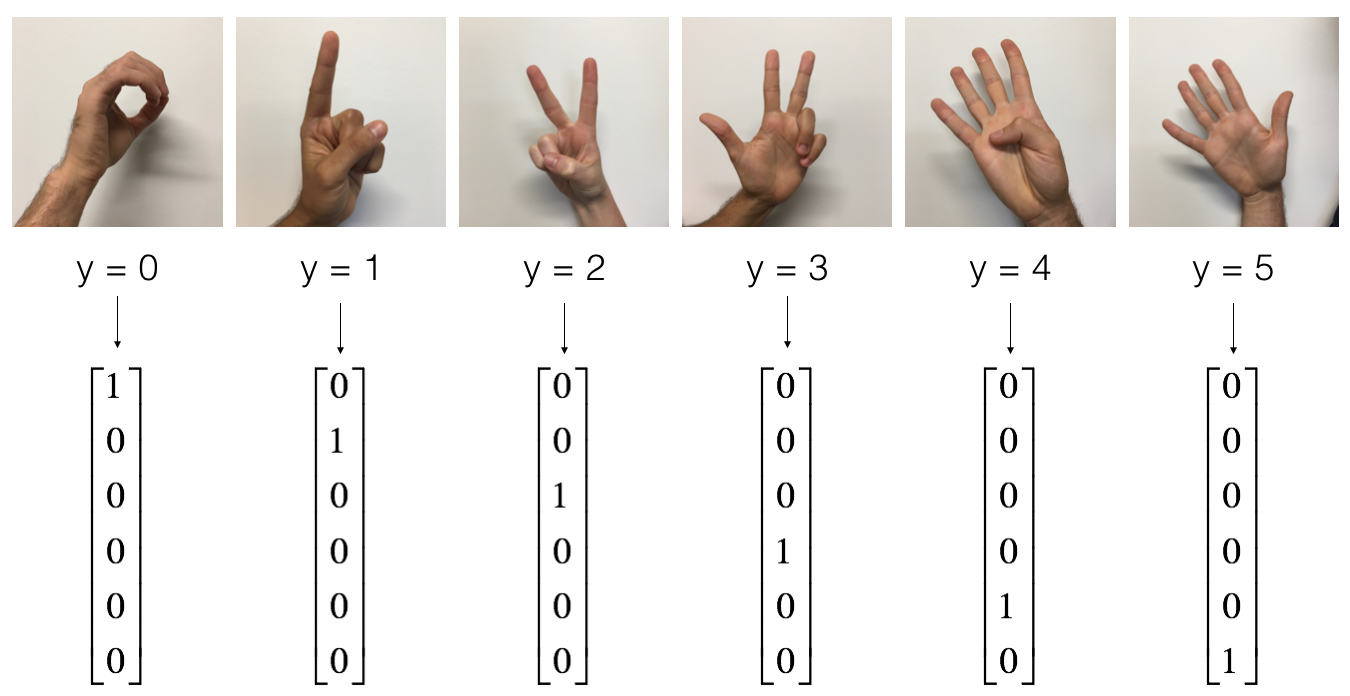
Figure 6 : SIGNS dataset

In [119]:
import h5py

def load_dataset():
    train_dataset = h5py.File('./data/train_signs.h5', "r")
    # your train set features
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])  # your train set labels

   
    test_dataset = h5py.File('./data/test_signs.h5', "r")
    # your test set features
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])  
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])  # your test set labels

    classes = np.array(test_dataset["list_classes"][:])  # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


    Run the following cell to train your model on 10 epochs with a batch size of 32. On a GPU, it should take less than 2 minutes.

In [120]:
model.fit(X_train, Y_train, batch_size=32, epochs=10)

Epoch 1/10
34/34 [==============================] - 52s 1s/step - loss: 2.4253 - accuracy: 0.4546
Epoch 2/10
34/34 [==============================] - 37s 1s/step - loss: 0.8426 - accuracy: 0.7407
Epoch 3/10
34/34 [==============================] - 36s 1s/step - loss: 0.4919 - accuracy: 0.8463
Epoch 4/10
34/34 [==============================] - 36s 1s/step - loss: 0.4770 - accuracy: 0.8500
Epoch 5/10
34/34 [==============================] - 36s 1s/step - loss: 0.6281 - accuracy: 0.8046
Epoch 6/10
34/34 [==============================] - 37s 1s/step - loss: 0.3309 - accuracy: 0.8796
Epoch 7/10
34/34 [==============================] - 36s 1s/step - loss: 0.2463 - accuracy: 0.9204
Epoch 8/10
34/34 [==============================] - 36s 1s/step - loss: 0.1444 - accuracy: 0.9500
Epoch 9/10
34/34 [==============================] - 36s 1s/step - loss: 0.0572 - accuracy: 0.9824
Epoch 10/10
34/34 [==============================] - 36s 1s/step - loss: 0.0468 - accuracy: 0.9778


    The exact values could not match, but don't worry about that. The important thing that you must see is that the loss value decreases, and the accuracy increases for the firsts 5 epochs.

    Let's see how this model (trained on only two epochs) performs on the test set.

In [121]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 2s 178ms/step - loss: 0.1909 - accuracy: 0.9583
Loss = 0.19094164669513702
Test Accuracy = 0.9583333134651184


    For the purposes of this assignment, you've been asked to train the model for ten epochs. You can see that it performs well. 

    After you have finished this official (graded) part of this assignment, you can also optionally train the ResNet for more iterations, if you want. It tends to get much better performance when trained for ~20 epochs, but this does take more than an hour when training on a CPU.

    Using a GPU, this ResNet50 model's weights were trained on the SIGNS dataset. You can load and run the trained model on the test set in the cells below. It may take ≈1min to load the model. Have fun!

In [113]:
#pretrained model
# pretrained_model = tf.keras.models.load_model('./resnet50.h5')
#print(pretrained_model.keys())

Pretrained model weights h5 file download issue

https://community.deeplearning.ai/t/unable-to-download-resnet50-h5-of-week-2s-assignment-residual-networks/35543

In [56]:
#evaluate the pretrained model on test set
# print(pretrained_model.keys())
# preds = pretrained_model.evaluate(X_test, Y_test)
# print ("Loss = " + str(preds[0]))
# print ("Test Accuracy = " + str(preds[1]))

In [61]:
#You can also print a summary of your model by running the following code.
# pre_trained_model.summary()

    Congratulations on finishing this assignment! You've now implemented a state-of-the-art image classification system! Woo hoo!

    ResNet50 is a powerful model for image classification when it's trained for an adequate number of iterations. Hopefully, from this point, you can use what you've learned and apply it to your own classification problem to perform state-of-the-art accuracy.

**What you should remember:**

- Very deep "plain" networks don't work in practice because vanishing gradients make them hard to train.
- Skip connections help address the Vanishing Gradient problem. They also make it easy for a ResNet block to learn an identity function.
- There are two main types of blocks: The identity block and the convolutional block.
- Very deep Residual Networks are built by stacking these blocks together.

### 5 - Test on Your Own Image (Optional/Ungraded)
    If you wish, you can also take a picture of your own hand and see the output of the model.
    
    Run the code and check if the algorithm is right!

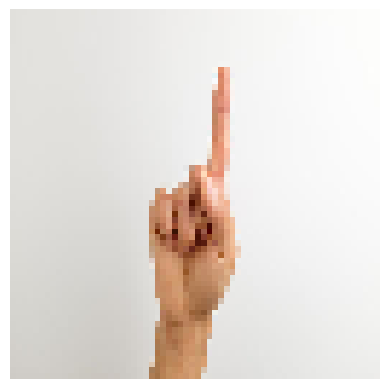

Input image shape: (64, 64, 3)
Input image shape: (1, 64, 64, 3)
1/1 [==============================] - 1s 933ms/step
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[2.6841494e-03 1.8658433e-03 6.0459787e-01 2.6354750e-04 2.3523708e-01
  1.5535149e-01]]
Class: 2


In [122]:
from tensorflow.keras.preprocessing import image

image_path = "./images/handtest_1.jpg"
myimage = image.load_img(image_path, target_size=(64, 64))
x = image.img_to_array(myimage).astype("uint8")
plt.imshow(x)
plt.axis("off")
plt.show()

print('Input image shape:', x.shape)

#preprocessing
x = np.expand_dims(x, axis=0)
#x = x.reshape(1, 64, 64, 3)
x = x / 255.0


#predict
print('Input image shape:', x.shape)
x_pred = model.predict(x)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", x_pred)
print("Class:", np.argmax(x_pred))


    Even though the model has high accuracy, it might be performing poorly on your own set of images. Notice that, the shape of the pictures, the lighting where the photos were taken, and all of the preprocessing steps can have an impact on the performance of the model. Considering everything you have learned in this specialization so far, what do you think might be the cause here?

    Hint: It might be related to some distributions. Can you come up with a potential solution ?

    

### 6 - Bibliography
This notebook presents the ResNet algorithm from He et al. (2015). The implementation here also took significant inspiration and follows the structure given in the GitHub repository of Francois Chollet:

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - Deep Residual Learning for Image Recognition (2015)
Francois Chollet's GitHub repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py

In [101]:
#Unit Tests
def identity_block_test(target):
    np.random.seed(1)
    #X = np.random.randn(3, 4, 4, 6).astype(np.float32)
    X1 = np.ones((1, 4, 4, 3)) * -1
    X2 = np.ones((1, 4, 4, 3)) * 1
    X3 = np.ones((1, 4, 4, 3)) * 3

    X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

    A3 = target(X,
                f = 2,
                layersfilters_nC = [4, 4, 3],
                initializer=lambda seed=0:tf.keras.initializers.constant(value=1),
                training=False)


    A3np = A3.numpy()
    assert tuple(A3np.shape) == (3, 4, 4, 3), "Shapes does not match. This is really weird"
    assert np.all(A3np >= 0), "The ReLu activation at the last layer is missing"
    resume = A3np[:,(0,-1),:,:].mean(axis = 3)

    assert np.floor(resume[1, 0, 0]) == 2 * np.floor(resume[1, 0, 3]), "Check the padding and strides"
    assert np.floor(resume[1, 0, 3]) == np.floor(resume[1, 1, 0]),     "Check the padding and strides"
    assert np.floor(resume[1, 1, 0]) == 2 * np.floor(resume[1, 1, 3]), "Check the padding and strides"
    assert np.floor(resume[1, 1, 0]) == 2 * np.floor(resume[1, 1, 3]), "Check the padding and strides"

    assert resume[1, 1, 0] - np.floor(resume[1, 1, 0]) > 0.7, "Looks like the BatchNormalization units are not working"

    assert np.allclose(resume, 
                       np.array([[[0.0,       0.0,       0.0,        0.0],
                                  [0.0,       0.0,       0.0,        0.0]],
                                 [[192.71236, 192.71236, 192.71236,  96.85619],
                                  [ 96.85619,  96.85619,  96.85619,  48.9281 ]],
                                 [[578.1371,   578.1371,  578.1371,  290.56854],
                                  [290.56854,  290.56854, 290.56854, 146.78427]]]), atol = 1e-5 ), "Wrong values with training=False"
    
    np.random.seed(1)
    A4 = target(X,
                f = 3,
                layersfilters_nC = [3, 3, 3],
                initializer=lambda seed=7:tf.keras.initializers.constant(value=1),
                training=True)
    A4np = A4.numpy()
    resume = A4np[:,(0,-1),:,:].mean(axis = 3)
    assert np.allclose(resume, 
                         np.array([[[0.,         0.,        0.,      0.,        ],
                                  [0.,         0.,        0.,        0.,        ]],
                                 [[0.37394285, 0.37394285, 0.37394285, 0.37394285],
                                  [0.37394285, 0.37394285, 0.37394285, 0.37394285]],
                                 [[3.2379014,  4.1394243,  4.1394243,  3.2379014 ],
                                  [3.2379014,  4.1394243,  4.1394243,  3.2379014 ]]]), atol = 1e-5 ), "Wrong values with training=True"

    print(colored("All tests passed!", "green"))

identity_block_test(identity_block)

All tests passed!


In [123]:
#comparator and summary
from termcolor import colored

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Dense


# Compare the two inputs
def comparator(learner, instructor):
    if len(learner) != len(instructor):
        raise AssertionError(f'Models does not have the same number of layers {len(learner)} != {len(instructor)}')
    for a, b in zip(learner, instructor):
        if tuple(a) != tuple(b):
            print(colored("Test failed", attrs=['bold']),
                  "\n Expected value \n\n", colored(f"{b}", "green"), 
                  "\n\n does not match the input value: \n\n", 
                  colored(f"{a}", "red"))
            raise AssertionError("Error in test") 
    print(colored("All tests passed!", "green"))

# extracts the description of a given model
def summary(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    result = []
    for layer in model.layers:
        descriptors = [layer.__class__.__name__, layer.output_shape, layer.count_params()]
        if (type(layer) == Conv2D):
            descriptors.append(layer.padding)
            descriptors.append(layer.activation.__name__)
            descriptors.append(layer.kernel_initializer.__class__.__name__)
        if (type(layer) == MaxPooling2D):
            descriptors.append(layer.pool_size)
            descriptors.append(layer.strides)
            descriptors.append(layer.padding)
        if (type(layer) == Dropout):
            descriptors.append(layer.rate)
        if (type(layer) == ZeroPadding2D):
            descriptors.append(layer.padding)
        if (type(layer) == Dense):
            descriptors.append(layer.activation.__name__)
        result.append(descriptors)
    return result

In [125]:
ResNet50_summary =[['InputLayer', [(None, 64, 64, 3)], 0],
['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))],
['Conv2D', (None, 32, 32, 64), 9472, 'valid', 'linear', 'GlorotUniform'],
['BatchNormalization', (None, 32, 32, 64), 256],
['Activation', (None, 32, 32, 64), 0],
['MaxPooling2D', (None, 15, 15, 64), 0, (3, 3), (2, 2), 'valid'],
['Conv2D', (None, 15, 15, 64), 4160, 'valid', 'linear', 'GlorotUniform'],
['BatchNormalization', (None, 15, 15, 64), 256],
['Activation', (None, 15, 15, 64), 0],
['Conv2D', (None, 15, 15, 64), 36928, 'same', 'linear', 'GlorotUniform'],
['BatchNormalization', (None, 15, 15, 64), 256],
['Activation', (None, 15, 15, 64), 0],
['Conv2D', (None, 15, 15, 256), 16640, 'valid', 'linear', 'GlorotUniform'],
['Conv2D', (None, 15, 15, 256), 16640, 'valid', 'linear', 'GlorotUniform'],
['BatchNormalization', (None, 15, 15, 256), 1024],
['BatchNormalization', (None, 15, 15, 256), 1024],
['Add', (None, 15, 15, 256), 0],
['Activation', (None, 15, 15, 256), 0],
['Conv2D', (None, 15, 15, 64), 16448, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 15, 15, 64), 256],
['Activation', (None, 15, 15, 64), 0],
['Conv2D', (None, 15, 15, 64), 36928, 'same', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 15, 15, 64), 256],
['Activation', (None, 15, 15, 64), 0],
['Conv2D', (None, 15, 15, 256), 16640, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 15, 15, 256), 1024],
['Add', (None, 15, 15, 256), 0],
['Activation', (None, 15, 15, 256), 0],
['Conv2D', (None, 15, 15, 64), 16448, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 15, 15, 64), 256],
['Activation', (None, 15, 15, 64), 0],
['Conv2D', (None, 15, 15, 64), 36928, 'same', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 15, 15, 64), 256],
['Activation', (None, 15, 15, 64), 0],
['Conv2D', (None, 15, 15, 256), 16640, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 15, 15, 256), 1024],
['Add', (None, 15, 15, 256), 0],
['Activation', (None, 15, 15, 256), 0],
['Conv2D', (None, 8, 8, 128), 32896, 'valid', 'linear', 'GlorotUniform'],
['BatchNormalization', (None, 8, 8, 128), 512],
['Activation', (None, 8, 8, 128), 0],
['Conv2D', (None, 8, 8, 128), 147584, 'same', 'linear', 'GlorotUniform'],
['BatchNormalization', (None, 8, 8, 128), 512],
['Activation', (None, 8, 8, 128), 0],
['Conv2D', (None, 8, 8, 512), 66048, 'valid', 'linear', 'GlorotUniform'],
['Conv2D', (None, 8, 8, 512), 131584, 'valid', 'linear', 'GlorotUniform'],
['BatchNormalization', (None, 8, 8, 512), 2048],
['BatchNormalization', (None, 8, 8, 512), 2048],
['Add', (None, 8, 8, 512), 0],
['Activation', (None, 8, 8, 512), 0],
['Conv2D', (None, 8, 8, 128), 65664, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 8, 8, 128), 512],
['Activation', (None, 8, 8, 128), 0],
['Conv2D', (None, 8, 8, 128), 147584, 'same', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 8, 8, 128), 512],
['Activation', (None, 8, 8, 128), 0],
['Conv2D', (None, 8, 8, 512), 66048, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 8, 8, 512), 2048],
['Add', (None, 8, 8, 512), 0],
['Activation', (None, 8, 8, 512), 0],
['Conv2D', (None, 8, 8, 128), 65664, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 8, 8, 128), 512],
['Activation', (None, 8, 8, 128), 0],
['Conv2D', (None, 8, 8, 128), 147584, 'same', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 8, 8, 128), 512],
['Activation', (None, 8, 8, 128), 0],
['Conv2D', (None, 8, 8, 512), 66048, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 8, 8, 512), 2048],
['Add', (None, 8, 8, 512), 0],
['Activation', (None, 8, 8, 512), 0],
['Conv2D', (None, 8, 8, 128), 65664, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 8, 8, 128), 512],
['Activation', (None, 8, 8, 128), 0],
['Conv2D', (None, 8, 8, 128), 147584, 'same', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 8, 8, 128), 512],
['Activation', (None, 8, 8, 128), 0],
['Conv2D', (None, 8, 8, 512), 66048, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 8, 8, 512), 2048],
['Add', (None, 8, 8, 512), 0],
['Activation', (None, 8, 8, 512), 0],
['Conv2D', (None, 4, 4, 256), 131328, 'valid', 'linear', 'GlorotUniform'],
['BatchNormalization', (None, 4, 4, 256), 1024],
['Activation', (None, 4, 4, 256), 0],
['Conv2D', (None, 4, 4, 256), 590080, 'same', 'linear', 'GlorotUniform'],
['BatchNormalization', (None, 4, 4, 256), 1024],
['Activation', (None, 4, 4, 256), 0],
['Conv2D', (None, 4, 4, 1024), 263168, 'valid', 'linear', 'GlorotUniform'],
['Conv2D', (None, 4, 4, 1024), 525312, 'valid', 'linear', 'GlorotUniform'],
['BatchNormalization', (None, 4, 4, 1024), 4096],
['BatchNormalization', (None, 4, 4, 1024), 4096],
['Add', (None, 4, 4, 1024), 0],
['Activation', (None, 4, 4, 1024), 0],
['Conv2D', (None, 4, 4, 256), 262400, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 4, 4, 256), 1024],
['Activation', (None, 4, 4, 256), 0],
['Conv2D', (None, 4, 4, 256), 590080, 'same', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 4, 4, 256), 1024],
['Activation', (None, 4, 4, 256), 0],
['Conv2D', (None, 4, 4, 1024), 263168, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 4, 4, 1024), 4096],
['Add', (None, 4, 4, 1024), 0],
['Activation', (None, 4, 4, 1024), 0],
['Conv2D', (None, 4, 4, 256), 262400, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 4, 4, 256), 1024],
['Activation', (None, 4, 4, 256), 0],
['Conv2D', (None, 4, 4, 256), 590080, 'same', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 4, 4, 256), 1024],
['Activation', (None, 4, 4, 256), 0],
['Conv2D', (None, 4, 4, 1024), 263168, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 4, 4, 1024), 4096],
['Add', (None, 4, 4, 1024), 0],
['Activation', (None, 4, 4, 1024), 0],
['Conv2D', (None, 4, 4, 256), 262400, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 4, 4, 256), 1024],
['Activation', (None, 4, 4, 256), 0],
['Conv2D', (None, 4, 4, 256), 590080, 'same', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 4, 4, 256), 1024],
['Activation', (None, 4, 4, 256), 0],
['Conv2D', (None, 4, 4, 1024), 263168, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 4, 4, 1024), 4096],
['Add', (None, 4, 4, 1024), 0],
['Activation', (None, 4, 4, 1024), 0],
['Conv2D', (None, 4, 4, 256), 262400, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 4, 4, 256), 1024],
['Activation', (None, 4, 4, 256), 0],
['Conv2D', (None, 4, 4, 256), 590080, 'same', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 4, 4, 256), 1024],
['Activation', (None, 4, 4, 256), 0],
['Conv2D', (None, 4, 4, 1024), 263168, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 4, 4, 1024), 4096],
['Add', (None, 4, 4, 1024), 0],
['Activation', (None, 4, 4, 1024), 0],
['Conv2D', (None, 4, 4, 256), 262400, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 4, 4, 256), 1024],
['Activation', (None, 4, 4, 256), 0],
['Conv2D', (None, 4, 4, 256), 590080, 'same', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 4, 4, 256), 1024],
['Activation', (None, 4, 4, 256), 0],
['Conv2D', (None, 4, 4, 1024), 263168, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 4, 4, 1024), 4096],
['Add', (None, 4, 4, 1024), 0],
['Activation', (None, 4, 4, 1024), 0],
['Conv2D', (None, 2, 2, 512), 524800, 'valid', 'linear', 'GlorotUniform'],
['BatchNormalization', (None, 2, 2, 512), 2048],
['Activation', (None, 2, 2, 512), 0],
['Conv2D', (None, 2, 2, 512), 2359808, 'same', 'linear', 'GlorotUniform'],
['BatchNormalization', (None, 2, 2, 512), 2048],
['Activation', (None, 2, 2, 512), 0],
['Conv2D', (None, 2, 2, 2048), 1050624, 'valid', 'linear', 'GlorotUniform'],
['Conv2D', (None, 2, 2, 2048), 2099200, 'valid', 'linear', 'GlorotUniform'],
['BatchNormalization', (None, 2, 2, 2048), 8192],
['BatchNormalization', (None, 2, 2, 2048), 8192],
['Add', (None, 2, 2, 2048), 0],
['Activation', (None, 2, 2, 2048), 0],
['Conv2D', (None, 2, 2, 512), 1049088, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 2, 2, 512), 2048],
['Activation', (None, 2, 2, 512), 0],
['Conv2D', (None, 2, 2, 512), 2359808, 'same', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 2, 2, 512), 2048],
['Activation', (None, 2, 2, 512), 0],
['Conv2D', (None, 2, 2, 2048), 1050624, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 2, 2, 2048), 8192],
['Add', (None, 2, 2, 2048), 0],
['Activation', (None, 2, 2, 2048), 0],
['Conv2D', (None, 2, 2, 512), 1049088, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 2, 2, 512), 2048],
['Activation', (None, 2, 2, 512), 0],
['Conv2D', (None, 2, 2, 512), 2359808, 'same', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 2, 2, 512), 2048],
['Activation', (None, 2, 2, 512), 0],
['Conv2D', (None, 2, 2, 2048), 1050624, 'valid', 'linear', 'RandomUniform'],
['BatchNormalization', (None, 2, 2, 2048), 8192],
['Add', (None, 2, 2, 2048), 0],
['Activation', (None, 2, 2, 2048), 0],
['AveragePooling2D', (None, 1, 1, 2048), 0],
['Flatten', (None, 2048), 0],
['Dense', (None, 6), 12294, 'softmax']]

model = ResNet50(input_shape = (64, 64, 3), classes = 6)
# print(summary(model))
comparator(summary(model), ResNet50_summary)

All tests passed!


In [ ]:
#code example on how to plot the gradient norms
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define your deep neural network model
def create_deep_neural_network():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dense(32, activation='relu'),
        # Add more layers as needed
    ])
    return model

# Define your dataset (X_train and y_train) and optimizer
(X_train, y_train), _ = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], -1).astype(np.float32) / 255.0
input_dim = X_train.shape[1]
model = create_deep_neural_network()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# Function to compute the gradient norm in the first layer
def compute_gradient_norm(model, X, y):
    with tf.GradientTape() as tape:
        predictions = model(X)
        loss = tf.keras.losses.mean_squared_error(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    return tf.norm(gradients[0])  # Assuming the first layer is what you're interested in

# Training loop
num_iterations = 100
gradient_norms = []

for iteration in range(num_iterations):
    # Replace this with your actual training loop
    for i in range(len(X_train)):
        X_batch = X_train[i:i+1]
        y_batch = y_train[i:i+1]
        optimizer.minimize(lambda: compute_gradient_norm(model, X_batch, y_batch), model.trainable_variables)
    
    # Calculate and store the gradient norm
    norm = compute_gradient_norm(model, X_batch, y_batch)
    gradient_norms.append(norm.numpy())

# Plot the gradient norm vs. iterations
plt.plot(range(num_iterations), gradient_norms)
plt.xlabel('Iterations')
plt.ylabel('Gradient Norm (First Layer)')
plt.title('Gradient Norm vs. Iterations')
plt.show()

In [ ]:
#Code to plot expected moving average of first layer gradients
#The expected moving average is typically used to visualize the smoothing effect on the gradients.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define your deep neural network model
def create_deep_neural_network():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dense(32, activation='relu'),
        # Add more layers as needed
    ])
    return model

# Define your dataset (X_train and y_train) and optimizer
# Replace this with your actual data and optimizer
(X_train, y_train), _ = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], -1).astype(np.float32) / 255.0
input_dim = X_train.shape[1]
model = create_deep_neural_network()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# Function to compute the gradient norm in the first layer
def compute_gradient_norm(model, X, y):
    with tf.GradientTape() as tape:
        predictions = model(X)
        loss = tf.keras.losses.mean_squared_error(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    return tf.norm(gradients[0])  # Assuming the first layer is what you're interested in

# Training loop
num_iterations = 100
gradient_norms = []
expected_moving_avg = []
beta = 0.9  # Smoothing parameter

for iteration in range(num_iterations):
    # Replace this with your actual training loop
    for i in range(len(X_train)):
        X_batch = X_train[i:i+1]
        y_batch = y_train[i:i+1]
        optimizer.minimize(lambda: compute_gradient_norm(model, X_batch, y_batch), model.trainable_variables)
    
    # Calculate and store the gradient norm
    norm = compute_gradient_norm(model, X_batch, y_batch)
    gradient_norms.append(norm.numpy())
    
    # Calculate the moving average of gradient norms
    if iteration == 0:
        moving_avg = norm.numpy()
    else:
        moving_avg = beta * moving_avg + (1 - beta) * norm.numpy()
    expected_moving_avg.append(moving_avg)

# Plot the gradient norm and expected moving average
plt.plot(range(num_iterations), gradient_norms, label='Gradient Norm')
plt.plot(range(num_iterations), expected_moving_avg, label='Expected Moving Average')
plt.xlabel('Iterations')
plt.ylabel('Gradient Norm / Moving Average')
plt.legend()
plt.title('Gradient Norm and Expected Moving Average vs. Iterations')
plt.show()


In [24]:
##Self Practice
import tensorflow.keras.layers as tfl
import h5py

#Resnet
def conv_block(a_in, f, filters, s, training=True, initializer=tf.keras.initializers.glorot_uniform):
    F1, F2, F3 = filters
    X_shortcut = a_in
    
    Z1 = tfl.Conv2D(kernel_size=(1, 1), filters=F1, strides=(s, s), padding="valid", kernel_initializer=initializer(seed=0))(a_in)
    Z1 = tfl.BatchNormalization(axis=3)(Z1, training=training)
    A1 = tfl.Activation("relu")(Z1)
    Z2 = tfl.Conv2D(kernel_size=(f, f), filters=F2, strides=(1, 1), padding="same", kernel_initializer=initializer(seed=0))(A1)
    Z2 = tfl.BatchNormalization(axis=3)(Z2, training=training)
    A2 = tfl.Activation("relu")(Z2)
    Z3 = tfl.Conv2D(kernel_size=(1, 1), filters=F3, strides=(1, 1), padding="valid", kernel_initializer=initializer(seed=0))(A2)
    Z3 = tfl.BatchNormalization(axis=3)(Z3, training=training)
    
    X_shortcut = tfl.Conv2D(kernel_size=(1, 1), filters=F3, strides=(s, s), padding="valid", kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = tfl.BatchNormalization(axis=3)(X_shortcut, training=training)
    X_shortcut = tfl.Activation("relu")(X_shortcut)
    
    Z3 = tfl.Add()([Z3, X_shortcut])
    A3 = tfl.Activation("relu")(Z3)
    
    return A3
    

def identity_block(a_in, f, filters, training=True, initializer=tf.keras.initializers.random_uniform):
    F1, F2, F3 = filters
    X_shortcut = a_in
    
    Z1 = tfl.Conv2D(kernel_size=(1, 1), filters=F1, strides=(1, 1), padding="valid", kernel_initializer=initializer(seed=0))(a_in)
    Z1 = tfl.BatchNormalization(axis=3)(Z1, training=training)
    A1 = tfl.Activation("relu")(Z1)
    Z2 = tfl.Conv2D(kernel_size=(f, f), filters=F2, strides=(1, 1), padding="same", kernel_initializer=initializer(seed=0))(A1)
    Z2 = tfl.BatchNormalization(axis=3)(Z2, training=training)
    A2 = tfl.Activation("relu")(Z2)
    Z3 = tfl.Conv2D(kernel_size=(1, 1), filters=F3, strides=(1, 1), padding="valid", kernel_initializer=initializer(seed=0))(A2)
    Z3 = tfl.BatchNormalization(axis=3)(Z3, training=training)
    Z3 = tfl.Add()([X_shortcut, Z3])
    A3 = tfl.Activation("relu")(Z3)
    
    return A3

def ResNet50(input_shape=(64, 64, 3), classes=6):
    
    inputs = tf.keras.Input(shape=input_shape)
    
    X = tfl.ZeroPadding2D(padding=(3, 3))(inputs)
    
    #Stage 1 - Stem
    X = tfl.Conv2D(kernel_size=(7, 7), filters=64, strides=(2, 2))(X)
    X = tfl.BatchNormalization(axis=3)(X)
    X = tfl.Activation("relu")(X)
    X = tfl.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(X)
    
    
    #ResNet Blocks
    #Stage 2 
    X = conv_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, f=3, filters=[64, 64, 256])
    X = identity_block(X, f=3, filters=[64, 64, 256])
    
    #Stage 3
    X = conv_block(X, f=3, filters=[128, 128, 512], s=2)
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])
    
    #Stage 4
    X = conv_block(X, f=3, filters=[256, 256, 1024], s=2)
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    
    #Stage 5
    X = conv_block(X, f=3, filters=[512, 512, 2048], s=2)
    X = identity_block(X, f=3, filters=[512, 512, 2048])
    X = identity_block(X, f=3, filters=[512, 512, 2048])
    
    #Global Average and Fully connected layers
    X = tfl.AveragePooling2D(pool_size=(2, 2))(X)
    X = tfl.Flatten()(X)
    outputs = tfl.Dense(classes, activation="softmax", kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0))(X)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

#Loading data
def load_data():
    train_dataset = h5py.File('./data/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 

    test_dataset = h5py.File('./data/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])   
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])  

    classes = np.array(test_dataset["list_classes"][:])  

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

#Preprocess data
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = load_data()
X_train = train_set_x_orig / 255.0
X_test = test_set_x_orig / 255.0

#Convert to one hot
def convert_one_hot(Y, classes):
    Y_one_hot = np.eye(classes)[Y.reshape(-1)].T
    return Y_one_hot

Y_train = convert_one_hot(train_set_y_orig, len(classes)).T
Y_test = convert_one_hot(test_set_y_orig, len(classes)).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [25]:
model = ResNet50()

#compiling
learning_rate = 0.001
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

#Training
history = model.fit(X_train, Y_train, epochs=30, batch_size=32)

Epoch 1/30
34/34 [==============================] - 50s 1s/step - loss: 1.9863 - accuracy: 0.4593
Epoch 2/30
34/34 [==============================] - 36s 1s/step - loss: 0.5545 - accuracy: 0.8093
Epoch 3/30
34/34 [==============================] - 36s 1s/step - loss: 0.8543 - accuracy: 0.7269
Epoch 4/30
34/34 [==============================] - 36s 1s/step - loss: 0.9557 - accuracy: 0.6898
Epoch 5/30
34/34 [==============================] - 36s 1s/step - loss: 0.4942 - accuracy: 0.8981
Epoch 6/30
34/34 [==============================] - 36s 1s/step - loss: 0.2448 - accuracy: 0.9222
Epoch 7/30
34/34 [==============================] - 37s 1s/step - loss: 0.3318 - accuracy: 0.9111
Epoch 8/30
34/34 [==============================] - 36s 1s/step - loss: 0.1284 - accuracy: 0.9602
Epoch 9/30
34/34 [==============================] - 38s 1s/step - loss: 0.1282 - accuracy: 0.9574
Epoch 10/30
34/34 [==============================] - 37s 1s/step - loss: 0.0573 - accuracy: 0.9787
Epoch 11/30
34/34 [

In [26]:
#Evaluation
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 2s 154ms/step - loss: 0.3050 - accuracy: 0.9083
Loss = 0.3049832880496979
Test Accuracy = 0.9083333611488342


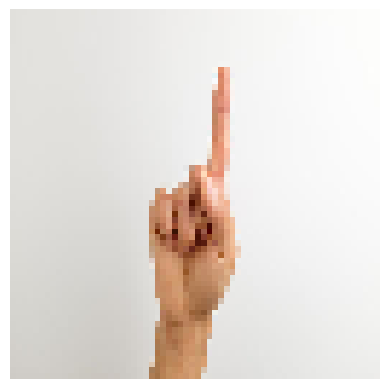

1/1 [==============================] - 0s 39ms/step
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[9.9913728e-01 1.0831576e-06 1.8370882e-04 1.2477291e-05 2.5548972e-04
  4.1000207e-04]]
Class: 0


In [30]:
# Test my own image
from tensorflow.keras.preprocessing import image
myimagepath = "./images/handtest_1.jpg"
myimage = image.load_img(myimagepath, target_size=(64, 64, 3))
x = image.img_to_array(myimage)

x = x / 255.0
plt.imshow(x)
x = np.expand_dims(x, 0)

plt.axis("off")
plt.show()

prediction = model.predict(x)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Class:", np.argmax(prediction))